# Domain Adaptation Tutorial for the MAX78000

## Setup
*This tutorial assumes you already have the ai8x-training, ai8x-synthesis, and sdk repos configured as shown [here](https://github.com/geffenc/DA_ai8x-training#installation). In addition to that setup, we need to install and configure Jupyter notebook within the virtual environment as shown [here](./Jupyter_setup.md).*

## Table of Contents
1. [**Context**: what is domain adaptation?](#context)
2. [**Overview**: what does this tutorial cover?](#overview)
3. [**Helper Functions**: define global functions](#helper-functions)
4. [**Quantization and Synthesis**: helpful scripts](#quantization-and-synthesis)
5. [**Step 1: Pretraining** (optional): pretrain the model on unlabled data](#step-1-pretraining)

---

## Context
CNN models have been very successful at image classification tasks when trained on large labeled datasets. However, when deploying these CNN models on real systems (i.e. the MAX78000) for live inference, the model accuracy can drop significantly due to differences in the data distribution seen at test time and at training time. For example, the training data might be high quality images with good lighting while data seen during inference might be coming from a low quality sensor or an environment with variable conditions.  

A few examples of this *domain shift* are shown below where the ***source** domain* represents images from a dataset and the ***target** domain* represents images from the MAX7800's onboard camera. As shown, images from the target domain may be lower quality, noisy, have diferent backgrounds, and have different object orientation and aspect ratio.

<center>

| | Mug | Backpack | Monitor | Keyboard |
| :----: | :----: | :----: | :----: | :----: |
| **Source** Domain | ![Dataset Mug](images/mug_source.jpg) | ![Dataset Backpack](images/backpack_source.jpg) | ![Dataset Monitor](images/monitor_source.jpg) | ![Dataset Keyboard](images/keyboard_source.jpg) |
| **Target** Domain | ![Camera Mug](images/mug_target.png) | ![Camera Backpack](images/backpack_target.png) | ![Camera Monitor](images/monitor_target.png) | ![Camera Keyboard](images/keyboard_target.png) |

</center>

In general, the task of adapting a model trained in some ***source** domain* to a semantically similar but different ***target** domain* is referred to as **domain adpatation**.

---

## Overview
This tutorial will cover how to potentially improve the *live inference* accuracy of an image classification model using a technique called **Few-Shot Adversarial Domain Adaptation** which will be referred to as *FADA* ([see the paper here](https://arxiv.org/pdf/1711.02536.pdf)).

Often a trained model will get > 95% accuracy on the test set but completely fail or not work very well once synthesized onto the MAX78000 due to the *domain shift* explained in [the context section](#context). A straightforward and effective solution to this problem would be to collect a large labeled dataset from the target domain and train the model on this custom dataset. However, large scale data collection and labeling requires a lot of time and effort and may not be straightforward without a proper setup for saving the images. 

FADA on the other hand is a method that can adapt a model trained on a source dataset using only 10 to 20 images per class from the target domain. This way only around 100 to 200 images (depending on the number of classes) need to be collected and labeled rather than thousands. A high level flowchart of the steps involved is shown below.

<center>

![High level overview](images/overview.svg)

</center>

At the minimum, only one extra step is added to the standard training workflow which is shown by the yellow box. However, better results can potentially be achieved by applying the optional steps. The rest of the tutorial will show step by step how to apply FADA to an actual application in this Jupyter notebook. To get started, go to [step 1](#step-1-pretraining).

---

## Helper Functions

These next four functions are used throughout the notebook and are defined here at the top for conveniance. These will need to be redfined every time the notebook is restarted.

---

### **Validation** Function

In [1]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("Index error")
        print("dataset length:",len(data_loader.dataset))
        steps = [validation_step for validation_step, batch in enumerate(data_loader)]
        print("final validation step:", steps[-1])

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        try:
            msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)
        except ZeroDivisionError:
            print("Zero division error")
            print(classerr.value())
            print(losses['objective_loss'])

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
   
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

### **Test** Function

In [2]:
def test(test_loader, model, model_path, loggers, conf, epoch=-1, tflogger=None):
    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
    msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)

### **Training** Function

In [3]:
def train(train_loader, val_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)
    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
    
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    msglogger.info('Training time: %s', datetime.now() - tic)

### **Embedding Visualization** Function

In [4]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,domain,to_pred=False):
    if domain == 0:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 1:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 2:
        _, _, source_test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_val = False, load_test=True)
        source_test_loader = DataLoader(source_test_set, batch_size=batch_size, shuffle=True)
        _, _, target_test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_val = False, load_test=True)
        target_test_loader = DataLoader(target_test_set, batch_size=batch_size, shuffle=True)

    

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    if domain == 0 or domain == 1:
        # get a batch of data
        (batch_imgs, batch_labels, batch_paths) = next(iter(test_loader))
        batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        preds = model(batch_imgs)
        embds = activation['fc1']

        # get the labels
        batch_label_strings = []
        for idx,label in enumerate(batch_labels):
            batch_label_strings.append(test_set.label_dict[label.item()])

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )
        
        if to_pred:
            print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))
    
    if domain == 2:

        # get a batch of data
        (source_batch_imgs, source_batch_labels, paths) = next(iter(source_test_loader))
        source_batch_imgs,source_batch_labels = source_batch_imgs.to(conf.device), source_batch_labels.to(conf.device)
        (target_batch_imgs, target_batch_labels, paths) = next(iter(target_test_loader))
        target_batch_imgs,target_batch_labels = target_batch_imgs.to(conf.device), target_batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        source_preds = model(source_batch_imgs)
        source_embds = activation['fc1']
        target_preds = model(target_batch_imgs)
        target_embds = activation['fc1']

        # get the labels
        source_batch_label_strings = []
        for idx,label in enumerate(source_batch_labels):
            source_batch_label_strings.append(source_test_set.label_dict[label.item()]+"_SRC")

        target_batch_label_strings = []
        for idx,label in enumerate(target_batch_labels):
            target_batch_label_strings.append(target_test_set.label_dict[label.item()]+"_TGT")

        batch_imgs = torch.cat((source_batch_imgs,target_batch_imgs))
        batch_labels = torch.cat((source_batch_labels,target_batch_labels))
        source_batch_label_strings.extend(target_batch_label_strings)
        embds = torch.cat((source_embds,target_embds))

        print(source_batch_label_strings)

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=source_batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )

## Quantization and Synthesis
These cells are defined here at the top for conveniance and provide the scripts needed to quantize and synthesize a trained model

---

### **Quantize** a model 
Use this script to quantize a trained model. To execute this cell, change the virtual environment to ai8x-synthesis.

In [ ]:
%reload_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py  jupyter_logging/asl_dcd_train_adv_SSL300k_k12___2022.07.26-120749/aslclassifier_qat_best.pth.tar jupyter_logging/asl_dcd_train_adv_SSL300k_k12___2022.07.26-120749/aslclassifier_qat_best-q.pth.tar --device MAX78000 -v

### **Evaluate** a quantized model  
Use these cells to test your quantized model to check if the accuracy hasn't degraded too much. To execute these cells, change the virtual environment to ai8x-training

#### Import needed modules

In [ ]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("classification_models")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

#### Load the model from the desired checkpoint

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
load_model_path = "jupyter_logging/asl_dcd_train_adv_SSL300k_k12___2022.07.26-120749/aslclassifier_qat_best-q.pth.tar"

# Change this path to match file system layout
data_path = "../Datasets/domain_adaptation/asl/target/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.ASLClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

#### Load the test data

In [ ]:
args = Args(act_mode_8bit=True)

# choose which dataset helper function you want
__, _, test_dataset, _ = asl_get_datasets((dataset_path, args), load_train=False, load_val=False, load_test=True, validation_split=0, \
                                                           fix_aug=None, deterministic=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Run a simple test loop

In [ ]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label, path in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

#### Before syntehsis, create a test image if needed and visualize it

In [ ]:
# set the file name accordingly
for image, label,path in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_office.npy', im_sample)

plt.imshow((image[0].detach().cpu().permute(1, 2, 0)+128)/255)
print(label[0])

### **Synthesize** a quantized model  
To execute these cell, change the virtual environment to ai8x-synthesis

In [ ]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix asl_DA_k12_aug --checkpoint-file ../ai8x-training/jupyter_logging/asl_dcd_train_adv_SSL300k_k12___2022.07.26-120749/aslclassifier_qat_best-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint


## **Step 1**: Pretraining
This section is optional but can provide a good starting point for your model before training on the source dataset. This can be particularly useful if your source dataset only has a couple hundred images per class and it is difficult to get good accuracy on it. 

However, this pretraining requires does require a lot of space (> 17 GB for the images) and compute (> 8 hrs with a 2080 Ti). This can be reduced if you only train on part of the dataset or use some other dataset. If you don't have the resources for this pretraining, a pretrained model has been provided.

To do pretraining, follow along with the cells below. Otherwise, skip to [step 2]()

---

### Downloading the dataset
The dataset is called PASS ([more information here](https://www.robots.ox.ac.uk/~vgg/data/pass/)) and is used to do self-supervised pretraining. A script called ```download_pass.sh``` has been provided in this directory. This script will install one partition of the dataset (150K images ~17GB) to the same directory as the script. Move the script to the directory where you store datasets and execute it there. It will take a while to complete.

I have installed the dataset in the folder ```../../Datasets``` which is at the same level as ```ai8x-training``` and ```ai8x-synthesis```. Recall that the location of this notebook is ```ai8x-training/DA_tutorial/DA_tutorial.ipynb```. The dataset will install as multiple subfolders which can be merged into a folder called ```train```.

Once the dataset has been downloaded move onto the next cells. Note that this method will work with other datasets as well so no need to install this dataset.

### Import the necessary modules and define some helper functions

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, '../')

# import models and datasets
from classification_datasets import *
from classification_models import *

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

### Define Training Configurations
The settings which may need to be changed have comments next to them

In [2]:
class Config:
    def __init__(self):
        self.dataset_name = "pass" # optional to change
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "backbone" # optional to change
        self.dimensions = (3,128,128) # set based on desired model input
        self.workers = 4 # optional to change
        self.batch_size = 512 # reduce if don't have a lot of memory
        self.validation_split = 0.0
        self.log_prefix = "pretrain" # optional to change
        self.log_dir = "jupyter_logging"
        self.data_path = "../../Datasets/PASS_dataset/train" # set to dataset location
        self.deterministic = False
        self.print_freq = 100
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':15, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = False
        self.start_epoch = 0

conf = Config()

### Set up the logger
* this will initialize logging and tensorboard for monitoring training
* nothing needs to be changed but you may want to add the log_prefix from above to the ```.gitignore```

In [3]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/DA_tutorial/jupyter_logging/pretrain___2022.07.27-101340/pretrain___2022.07.27-101340.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7f7fd45c2670>
num_classes=0
model_name=backbone
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 15, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



### Create and visualize the dataset
* This will create the dataset using ```pass_get_datasets()``` and ```PassDataset``` class in ```classification_datasets.py```.
* Each sample is a pair of augmented images. A random batch is visualized below.

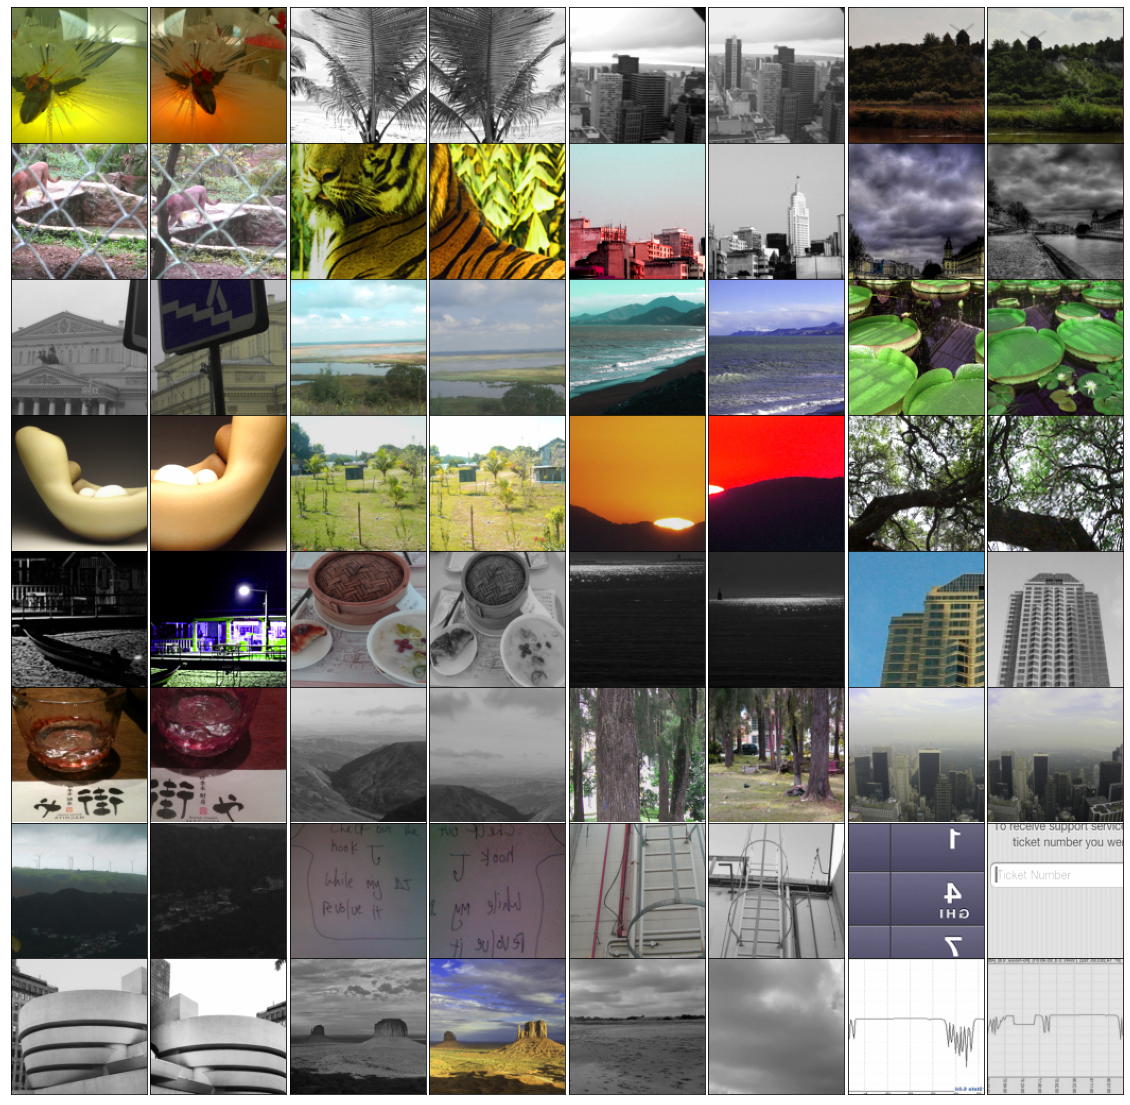

In [4]:
train_dataset = conf.dataset_fn((conf.data_path, args),conf)
train_dataset.visualize_batch()

### Create the training dataloader

In [5]:
# create the data loader
train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers,pin_memory=True,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d', len(train_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=300000
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


### Set up the device, cuda or cpu

In [6]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


### Set up the model for training
* the only line that needs to be changed is ```model = ClassifierBackbone()``` if you have your own model that you want to define

In [7]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = ClassifierBackbone() # edit this to your model class
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ClassifierBackbone(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (

Configuring device: MAX78000, simulate=False.


Number of Model Params: 287560


### Set up optimizer, loss, and learning schedule
* nothing needs to be changed

In [8]:
# self-supervised loss
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss


# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[15, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({15: 1, 35: 1, 100: 1}) gamma: 0.5


### Define the forward function
* this generalizes the way we do a forward pass so we can reuse the training/validation/test functions for different models
* no need to change this

In [9]:
def SSL_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = SSL_forward

### Train the model
* define the [train function](#helper-functions) if you haven't already
* monitor with tensorboard ```tensorboard --logdir='./jupyer_logging```
    * if using a remote machine, use the ```--port 0``` option

In [ ]:
train(train_loader, None, model,conf)

## **Step 2**: Train Model on ASL dataset  
In this step we will start training on the dataset used for the desired task. For this tutorial that will be the ASL dataset for sign language classification.

* If you did pretraining or plan to use the pretrained model then this step will be fine-tuning
    * If you defined your own architecture then you will need to define a second architecture for classification that loads the pretrained weights. Refer to ```ASLClassifier``` as a reference
* If you want to train from scratch, then you will need to define your own model in ```classification_models.py```. Feel free to use the ```ClassifierBackbone``` architecture with an extra layer for classification.

---

### Downloading the Dataset
The dataset is publicly available on kaggle at [this link](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). 
* Install it into the same ```../../Datasets/``` folder from before. I have placed it into ```../../Datasets/asl/source/``` since this is the **source dataset**
* Next we need to split this dataset into *train* and *test* subsets. A python script called ```dataset_split.py``` has been provided for this. Move it to the ```../../Datasets/``` folder. At the bottom of the script specify the path to the dataset and the relative test-train split you want
* When you run this script it will create a train and test folder within the ```../../Datasets/asl/source/``` directory and leave the original dataset as is in case you need it or want a different split later.
* This dataset contains 29 classes. Since you will need to collect your own data later in the tutorial, feel free to only use a subset (e.g. 5-10 classes) to avoid needing to collect 29 classes of data.
* With the dataset installed, follow the remaining steps

### 0.**Setup** Training

### Import the necessary modules and define some helper functions

In [15]:
# use this if changed submodules like data augmentation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, '../')

# import models and datasets
from classification_datasets import *
from classification_models import *

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

ModuleNotFoundError: No module named 'nnplot'

### Define Training Configurations
Feel free to modify the hyperparameters. A few tips for training are below.

* Once you find a set of potentially good hyperparameters, fix them and find the average validation accuracy over multiple runs (similar to k-fold) to see if you get consistent performance on several validation splits.
* By default a random validation split is selected each time unless ```deterministic = false```
* I have provided a way to fix the random seed (by default ```aug_seeed = None```) for data augmentation as well since certain augmentations may result in better validation accuracy. During exploration, the augmentation random seed will be logged each time so you can fix it once you find a good configuration to evaluate your hyperparameters.
* Only evaluate on the test set once you are finished tuning the model parameters. The results on the test set are the most meaningful this way.  
* In general strive for > 90% average validation accuracy (depending on the application requirements) because accuracy on this 'clean' source dataset is an upper bound in some sense on accuracy for target dataset. For this specific dataset you should get 99%.

In [52]:
class Config:
    def __init__(self):
        self.dataset_name = "asl" # optional to change
        self.dataset_fn = asl_get_datasets # see this function to change augmentations
        self.num_classes = 29 # change this if using a subset of the classes
        self.model_name = "aslclassifier" # optional to change
        self.dimensions = (3,128,128) # set to model input dimensions
        self.workers = 4 # optional to change
        self.batch_size = 64 # optional to change
        self.validation_split = 0.1 # optional to change
        self.log_prefix = "finetune_asl_base_ev1" # optional to change
        self.log_dir = "jupyter_logging"
        self.data_path = "../../Datasets/asl/source/" # set to dataset location
        self.deterministic = False # only set this if want to be able to replicate trianing exactly
        self.aug_seed = None # fix this once you want to evaluate hyperparameters
        self.print_freq = 50
        # change this to the subset of labels you want to use
        self.labels = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space')
        self.lr = 0.001 # optional to change
        self.num_epochs = 12 # optional to change
        self.qat_policy = {'start_epoch':4, 'weight_bits':8} # optional to change
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

#### Set up the logger

In [53]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/DA_tutorial/jupyter_logging/finetune_asl_base_ev1___2022.07.27-115750/finetune_asl_base_ev1___2022.07.27-115750.log
dataset_name:asl
dataset_fn=<function asl_get_datasets at 0x7f6f9422c040>
num_classes=29
model_name=aslclassifier
dimensions=(3, 128, 128)
batch_size=64
validation_split=0.1
lr=0.001000
num_epochs=12
qat_policy={'start_epoch': 4, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



#### Create the training, validation, and test datasets and dataloaders

Dataset sizes:
	training=70470
	validation=7830
	test=8700
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-5.0, 5.0], translate=(0.1, 0.1))
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)
Augmentation Seed:1806839773


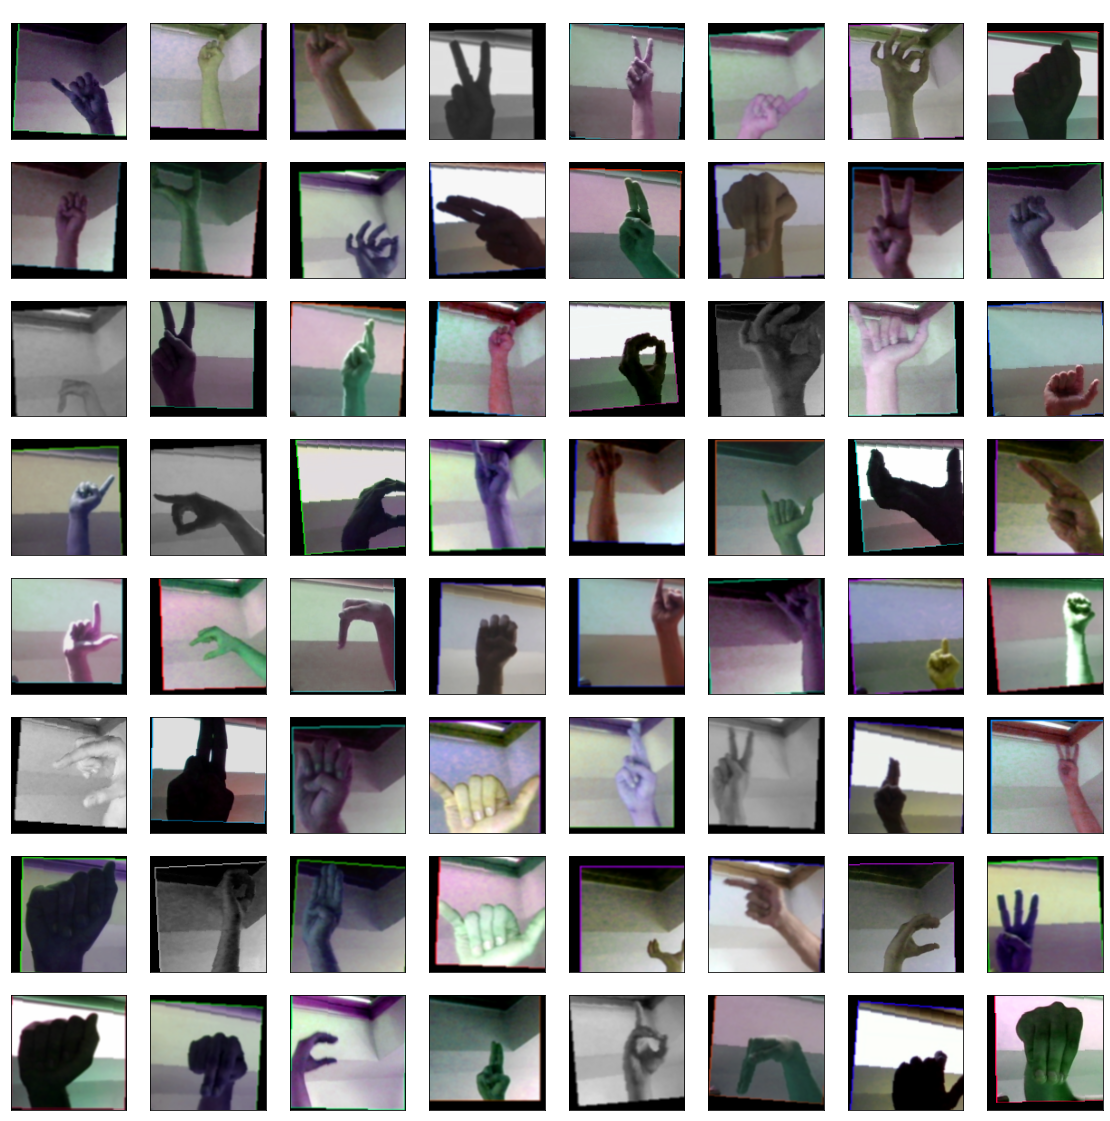

In [54]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset, val_dataset, test_dataset, aug_seed = conf.dataset_fn((conf.data_path, args), conf, load_train=True, load_val=True, load_test=True)

train_dataset.visualize_batch()


train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True, worker_init_fn=worker_init_fn,shuffle=True)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s\nAugmentation Seed:%s',train_loader.dataset.transform,aug_seed)

#### Set up the device

In [55]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


#### Set up the model
* only line that needs to be changed is the model class

In [56]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = ASLClassifier() # set the model
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


#### Set up the optimizer and loss
* change the learning rate schedule if you want

In [57]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[4,8, 20,100], gamma=0.75)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({4: 1, 8: 1, 20: 1, 100: 1}) gamma: 0.75


#### Define the forward function

In [58]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target, path = batch[0].to(conf.device), batch[1].to(conf.device), batch[2]

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

### 1.**Train** the model
* define the [train function](#helper-functions) if you haven't already
* monitor with tensorboard ```tensorboard --logdir='./jupyer_logging```
    * if using a remote machine, use the ```--port 0``` option

In [59]:
train(train_loader, val_loader, model,conf)

Training epoch: 70470 samples (64 per mini-batch)
Epoch: [0][   50/ 1102]    objective_loss 3.370062                                        LR 0.001000    
Epoch: [0][  100/ 1102]    objective_loss 3.370300                                        LR 0.001000    
Epoch: [0][  150/ 1102]    objective_loss 3.369880                                        LR 0.001000    
Epoch: [0][  200/ 1102]    objective_loss 3.370032                                        LR 0.001000    
Epoch: [0][  250/ 1102]    objective_loss 3.370263                                        LR 0.001000    
Epoch: [0][  300/ 1102]    objective_loss 3.370015                                        LR 0.001000    
Epoch: [0][  350/ 1102]    objective_loss 3.369934                                        LR 0.001000    
Epoch: [0][  400/ 1102]    objective_loss 3.369855                                        LR 0.001000    
Epoch: [0][  450/ 1102]    objective_loss 3.369930                                        LR 0.001000 

KeyboardInterrupt: 